In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

In [2]:
train_df = pd.read_csv(r'C:\Users\Lenovo\Downloads\train.csv')
test_df = pd.read_csv(r'C:\Users\Lenovo\Downloads\test.csv')
sample_submission_df = pd.read_csv(r'C:\Users\Lenovo\Downloads\sample_submission.csv')

In [3]:
train_df.head(3)

,ID,Sex,Bachelor,Age,Graduated,Career,Work Experience,Family Expenses,Family Size,Variable,Segmentation,Description
0,1462220581,Male,No,41,Yes,Fashion Designer,2,Low,3,Dog_6,Akshat,The specimen is reliable and experienced.
1,1462220232,Female,Yes,38,Yes,HR,0,Average,2,Dog_6,Akshat,The specimen is reliable and experienced.
2,1462226544,Male,Yes,41,Yes,Fashion Designer,0,High,5,Dog_6,Bhavesh,The specimen is reliable and experienced.


In [4]:
test_df.head(3)

,ID,Sex,Bachelor,Age,Graduated,Career,Work Experience,Family Expenses,Family Size,Variable,Description
0,1462224759,Female,Yes,42.0,No,Scientist,4.0,Low,1.0,Dog_6,The specimen is reliable and experienced.
1,1462220081,Female,No,41.0,Yes,Fashion Designer,0.0,Low,1.0,Dog_6,The specimen is reliable and experienced.
2,1462226086,Female,No,18.0,No,Doctor,2.0,Low,5.0,Dog_6,The specimen is rather joyful than responsible.


In [5]:
train_df['Variable'].unique()

array(['Dog_6', 'Dog_2', 'Dog_4', nan, 'Dog_7', 'Dog_3', 'Dog_1', 'Dog_5'],
      dtype=object)

In [6]:
train_df.isnull().sum()

ID                   0
Sex                 32
Bachelor           124
Age                 22
Graduated           69
Career             113
Work Experience    573
Family Expenses     31
Family  Size       249
Variable            52
Segmentation         0
Description          0
dtype: int64

In [7]:
test_df.isnull().sum()

ID                   0
Sex                 20
Bachelor            47
Age                 14
Graduated           33
Career              43
Work Experience    267
Family Expenses      7
Family  Size       103
Variable            24
Description          0
dtype: int64

Data preprocessing

In [8]:
# Cell 3: Initial Data Inspection and Cleaning
print("--- Initial Info for Train DataFrame ---")
train_df.info()
print("\n--- Initial Missing Values in Train DataFrame ---")
print(train_df.isnull().sum())

print("\n--- Initial Info for Test DataFrame ---")
test_df.info()
print("\n--- Initial Missing Values in Test DataFrame ---")
print(test_df.isnull().sum())

# Convert problematic columns to numeric, coercing errors to NaN
for col in ['Age', 'Work Experience', 'Family  Size']: # Note the double space in 'Family  Size'
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

print("\n--- Train DataFrame Info After Numeric Conversion ---")
train_df.info()
print("\n--- Test DataFrame Info After Numeric Conversion ---")
test_df.info()

print("\nData cleaning of numeric columns complete.")

--- Initial Info for Train DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               5647 non-null   int64 
 1   Sex              5615 non-null   object
 2   Bachelor         5523 non-null   object
 3   Age              5625 non-null   object
 4   Graduated        5578 non-null   object
 5   Career           5534 non-null   object
 6   Work Experience  5074 non-null   object
 7   Family Expenses  5616 non-null   object
 8   Family  Size     5398 non-null   object
 9   Variable         5595 non-null   object
 10  Segmentation     5647 non-null   object
 11  Description      5647 non-null   object
dtypes: int64(1), object(11)
memory usage: 529.5+ KB

--- Initial Missing Values in Train DataFrame ---
ID                   0
Sex                 32
Bachelor           124
Age                 22
Graduated           69
Car

Exploratory Data Analysis 

Target variable distribution in train_df:
Segmentation
Darsh        0.283690
Chaitanya    0.243846
Akshat       0.239419
Bhavesh      0.233044
Name: proportion, dtype: float64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16432\2451246716.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='Segmentation', palette='viridis', order=train_df['Segmentation'].value_counts().index)


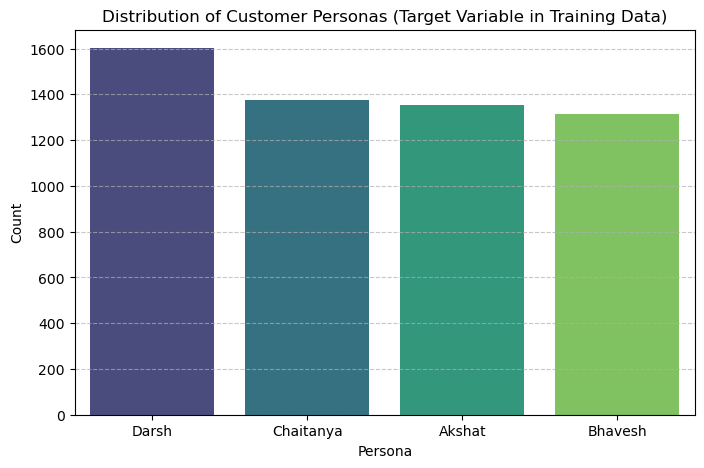


Target variable distribution analysis complete.


In [9]:
# Cell 4: Exploratory Data Analysis (EDA) - Target Variable Distribution
print("Target variable distribution in train_df:")
print(train_df['Segmentation'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Segmentation', palette='viridis', order=train_df['Segmentation'].value_counts().index)
plt.title('Distribution of Customer Personas (Target Variable in Training Data)')
plt.xlabel('Persona')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nTarget variable distribution analysis complete.")

Feature Engineering and Data Splitting

In [10]:
# Drop 'ID' and 'Description' from both train and test sets
train_df_processed = train_df.drop(columns=['ID', 'Description'])
test_df_processed_for_pred = test_df.drop(columns=['ID', 'Description'], errors='ignore')

# Separate features (X) and target (y) for training data
X = train_df_processed.drop('Segmentation', axis=1)
y = train_df_processed['Segmentation']

# Encode the target variable (e.g., 'Akshat' -> 0, 'Bhavesh' -> 1, etc.)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Original target classes: {le.classes_}")
print(f"Encoded target samples (first 5): {y_encoded[:5]}")

# Identify categorical and numerical columns for preprocessing
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nCategorical columns identified for preprocessing: {categorical_cols}")
print(f"Numerical columns identified for preprocessing: {numerical_cols}")

# Split the training data into training and validation sets
# stratify=y_encoded ensures that the proportion of each persona is maintained in both sets.
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Validation data shape (X_val): {X_val.shape}")
print(f"Training target shape (y_train): {y_train.shape}")
print(f"Validation target shape (y_val): {y_val.shape}")

print("\nData splitting and initial feature preparation complete.")

Original target classes: ['Akshat' 'Bhavesh' 'Chaitanya' 'Darsh']
Encoded target samples (first 5): [0 0 1 3 1]

Categorical columns identified for preprocessing: ['Sex', 'Bachelor', 'Graduated', 'Career', 'Family Expenses', 'Variable']
Numerical columns identified for preprocessing: ['Age', 'Work Experience', 'Family  Size']

Training data shape (X_train): (4517, 9)
Validation data shape (X_val): (1130, 9)
Training target shape (y_train): (4517,)
Validation target shape (y_val): (1130,)

Data splitting and initial feature preparation complete.


Define Preprocessing and Model Pipeline

In [11]:
# Define preprocessing steps for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Fill missing numerical values with the mean
    ('scaler', StandardScaler()) # Scale numerical features
])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing categorical values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Convert categorical variables into one-hot encoded features
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Check for class imbalance to decide whether to use SMOTE
class_counts = pd.Series(y_encoded).value_counts()
if class_counts.min() / class_counts.max() < 0.5: # Example threshold for imbalance
    print("\n--- Detected potential class imbalance. SMOTE will be included in the pipeline. ---")
    use_smote = True
else:
    print("\n--- Class balance seems okay. SMOTE will not be used. ---")
    use_smote = False

# Define the full model pipeline (preprocessing + classifier)
# We will use this pipeline as the `estimator` for GridSearchCV
if use_smote:
    base_model_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ])
else:
    base_model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ])

print("\nBase model pipeline defined (Preprocessor + XGBoost Classifier).")
if use_smote:
    print("SMOTE is set to be included in the pipeline for handling class imbalance.")


--- Class balance seems okay. SMOTE will not be used. ---

Base model pipeline defined (Preprocessor + XGBoost Classifier).


Hyperparameter Tuning (Crucial for High Accuracy)

In [12]:
print(f"\n--- Starting Hyperparameter Tuning for XGBoost (This may take a while) ---")

# Define a comprehensive parameter grid for XGBoost.
# These values are chosen to explore a good range for common XGBoost parameters.
param_grid = {
    'classifier__n_estimators': [150, 250, 400], # Number of boosting rounds
    'classifier__max_depth': [3, 5, 7],       # Maximum depth of a tree
    'classifier__learning_rate': [0.01, 0.05, 0.1], # Step size shrinkage
    'classifier__subsample': [0.7, 0.9],     # Subsample ratio of the training instance
    'classifier__colsample_bytree': [0.7, 0.9],    # Subsample ratio of columns when constructing each tree
    'classifier__gamma': [0, 0.1, 0.2]       # Minimum loss reduction required to make a further partition
}

# Use StratifiedKFold for cross-validation to maintain class balance across folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
# scoring='f1_weighted' is robust for multi-class classification, especially with imbalance
grid_search = GridSearchCV(
    estimator=base_model_pipeline, # Use the base pipeline defined earlier
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_weighted', # Optimize for weighted F1-score
    n_jobs=-1, # Use all available CPU cores for faster computation
    verbose=2 # Show progress during the search
)

# Fit GridSearchCV on the full training data (X, y_encoded)
# The best model found will be used for final predictions
grid_search.fit(X, y_encoded) # Fit on the full training data for final model

print("\n--- Hyperparameter Tuning Results ---")
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1-score (weighted):", grid_search.best_score_)

# Update the model_pipeline to the best estimator found by GridSearchCV
model_pipeline = grid_search.best_estimator_
print("\nModel pipeline updated with best parameters from GridSearchCV.")


--- Starting Hyperparameter Tuning for XGBoost (This may take a while) ---
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Hyperparameter Tuning Results ---
Best parameters found: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 150, 'classifier__subsample': 0.7}
Best cross-validation F1-score (weighted): 0.5330022020519188

Model pipeline updated with best parameters from GridSearchCV.


Final Model Evaluation on Validation Set

In [15]:
from sklearn.metrics import f1_score


--- Final Model Evaluation on Validation Set (after tuning) ---
Accuracy on Validation Set: 0.6513

Classification Report on Validation Set:
               precision    recall  f1-score   support

      Akshat       0.58      0.60      0.59       270
     Bhavesh       0.60      0.51      0.55       263
   Chaitanya       0.66      0.64      0.65       276
       Darsh       0.73      0.82      0.78       321

    accuracy                           0.65      1130
   macro avg       0.64      0.64      0.64      1130
weighted avg       0.65      0.65      0.65      1130



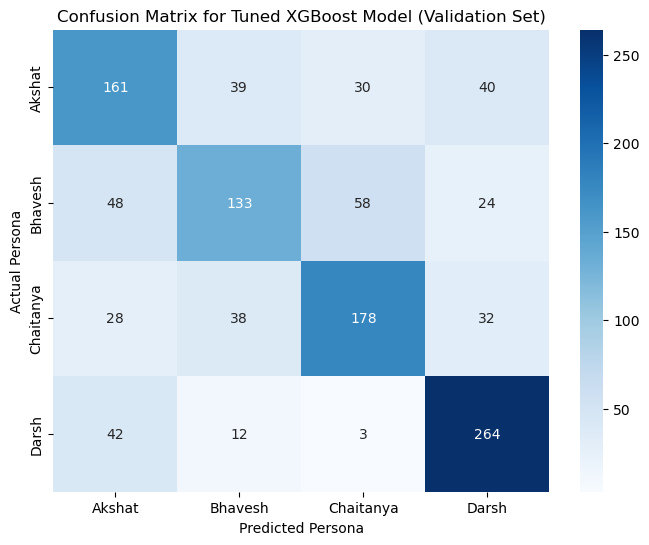


Final model evaluation complete.


In [16]:
# Cell 8: Final Model Evaluation on Validation Set

print("\n--- Final Model Evaluation on Validation Set (after tuning) ---")

# Make predictions on the validation set using the best model
y_pred_val = model_pipeline.predict(X_val)

# Calculate Accuracy
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Accuracy on Validation Set: {accuracy_val:.4f}")

# Generate Classification Report
report_val = classification_report(y_val, y_pred_val, target_names=le.classes_)
print("\nClassification Report on Validation Set:\n", report_val)

# Plot Confusion Matrix
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Tuned XGBoost Model (Validation Set)')
plt.xlabel('Predicted Persona')
plt.ylabel('Actual Persona')
plt.show()

print("\nFinal model evaluation complete.")

Model Persistence

In [17]:
# Cell 9: Model Persistence (Saving)
model_filename = 'ecocart_persona_predictor_model_optimized1 .pkl'
label_encoder_filename = 'label_encoder.pkl' # Same as before, but good to ensure it's saved

joblib.dump(model_pipeline, model_filename)
joblib.dump(le, label_encoder_filename)

print(f"\n--- Optimized model saved as '{model_filename}' ---")
print(f"--- LabelEncoder saved as '{label_encoder_filename}' ---")


--- Optimized model saved as 'ecocart_persona_predictor_model_optimized1 .pkl' ---
--- LabelEncoder saved as 'label_encoder.pkl' ---


 Prediction on New Data (Test Dataset) and Submission File Generation

In [18]:
# Cell 10: Prediction on New Data (test.csv) and Submission File Generation

# Load the trained model and LabelEncoder (in case you run this cell independently)
print(f"\n--- Loading the saved optimized model: '{model_filename}' ---")
loaded_model_pipeline = joblib.load(model_filename)
loaded_label_encoder = joblib.load(label_encoder_filename)
print("Optimized model and LabelEncoder loaded successfully.")

# Prepare the test dataset for prediction
# test_df_processed_for_pred was already created in Step 5
print("\n--- Making predictions on the provided test.csv data ---")
test_predictions_encoded = loaded_model_pipeline.predict(test_df_processed_for_pred)

# Inverse transform the numerical predictions back to original persona names
test_predictions_personas = loaded_label_encoder.inverse_transform(test_predictions_encoded)

# Create the final submission DataFrame
submission_df = pd.DataFrame({'ID': test_df['ID'], 'Segmentation': test_predictions_personas})

# Save the submission file to CSV
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\n--- Submission file '{submission_filename}' created successfully ---")
print("Submission file head:")
print(submission_df.head())
print("\nCounts of predicted personas in the submission file:")
print(submission_df['Segmentation'].value_counts())

print("\n--- Prediction process complete. ---")


--- Loading the saved optimized model: 'ecocart_persona_predictor_model_optimized1 .pkl' ---
Optimized model and LabelEncoder loaded successfully.

--- Making predictions on the provided test.csv data ---

--- Submission file 'submission.csv' created successfully ---
Submission file head:
           ID Segmentation
0  1462224759       Akshat
1  1462220081       Akshat
2  1462226086        Darsh
3  1462224440        Darsh
4  1462222905        Darsh

Counts of predicted personas in the submission file:
Segmentation
Darsh        762
Akshat       604
Chaitanya    585
Bhavesh      470
Name: count, dtype: int64

--- Prediction process complete. ---


In [31]:
import pandas as pd
import numpy as np
import joblib
import os

# --- Configuration ---
MODEL_PATH = 'ecocart_persona_predictor_model_optimized.pkl' # Use the optimized model
LABEL_ENCODER_PATH = 'label_encoder.pkl'

# --- Load Model and LabelEncoder ---
try:
    model_pipeline = joblib.load(MODEL_PATH)
    label_encoder = joblib.load(LABEL_ENCODER_PATH)
    print(f"Model and LabelEncoder loaded successfully from '{MODEL_PATH}' and '{LABEL_ENCODER_PATH}'.")
except FileNotFoundError:
    print(f"Error: Model or LabelEncoder file not found. Make sure '{MODEL_PATH}' and '{LABEL_ENCODER_PATH}' are in the same directory.")
    print("Please ensure you have run the full Jupyter Notebook code to train and save these files.")
    exit() # Exit if files are missing
except Exception as e:
    print(f"An error occurred loading the model or LabelEncoder: {e}")
    exit()

# --- Input Data for Prediction ---
# Your provided data: Female	Yes	42	No	Scientist	4	Low	1	Dog_6
input_data = {
    'Sex': ['Female'],
    'Bachelor': ['No'],
    'Age': [32],
    'Graduated': ['Yes'],
    'Career': ['HR'],
    'Work Experience': [8],
    'Family Expenses': ['High'],
    'Family  Size': [4], # IMPORTANT: Note the double space in 'Family  Size'
    'Variable': ['Dog_8']
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(input_data)

# Ensure numeric columns are correctly typed (coercing errors to handle potential non-numeric input)
for col in ['Age', 'Work Experience', 'Family  Size']:
    input_df[col] = pd.to_numeric(input_df[col], errors='coerce')

# --- Make Prediction ---
try:
    # The model_pipeline handles all preprocessing (imputation, scaling, encoding) internally
    predicted_encoded = model_pipeline.predict(input_df)

    # Inverse transform to get the persona name
    predicted_persona = label_encoder.inverse_transform(predicted_encoded)[0]

    print(f"\n--- Prediction Result ---")
    print(f"Input Customer Data:\n{input_df.iloc[0].to_string()}")
    print(f"\nPredicted Persona: **{predicted_persona}**")

except Exception as e:
    print(f"An error occurred during prediction: {e}")
    print("Please ensure the input data format and column names match the training data.")

Model and LabelEncoder loaded successfully from 'ecocart_persona_predictor_model_optimized.pkl' and 'label_encoder.pkl'.

--- Prediction Result ---
Input Customer Data:
Sex                Female
Bachelor               No
Age                    32
Graduated             Yes
Career                 HR
Work Experience         8
Family Expenses      High
Family  Size            4
Variable            Dog_8

Predicted Persona: **Darsh**
